In [1]:
%pylab inline
from pyspark import SparkContext
sc = SparkContext("local[2]", "First Spark App")

Populating the interactive namespace from numpy and matplotlib


## Exploring the User Dataset

In [6]:
# replace this PATH with the correct path to the MovieLens dataset on your computer
import os

PATH=os.path.expanduser("~/test_data")
user_data = sc.textFile("%s/ml-100k/u.user" % PATH)
user_data.first()

u'1|24|M|technician|85711'

In [7]:
user_fields = user_data.map(lambda line: line.split("|"))
num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()
print "Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, num_genders, num_occupations, num_zipcodes)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


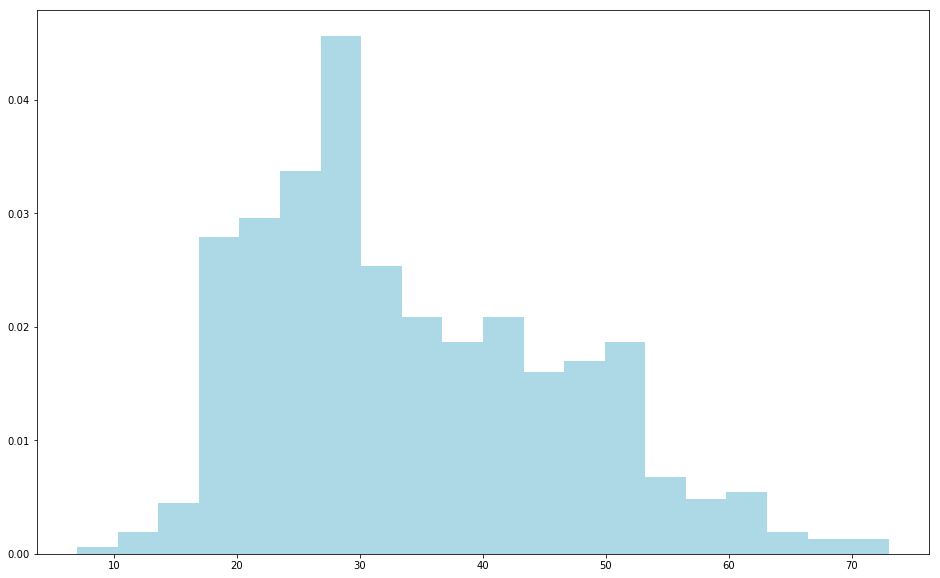

In [8]:
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages, bins=20, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

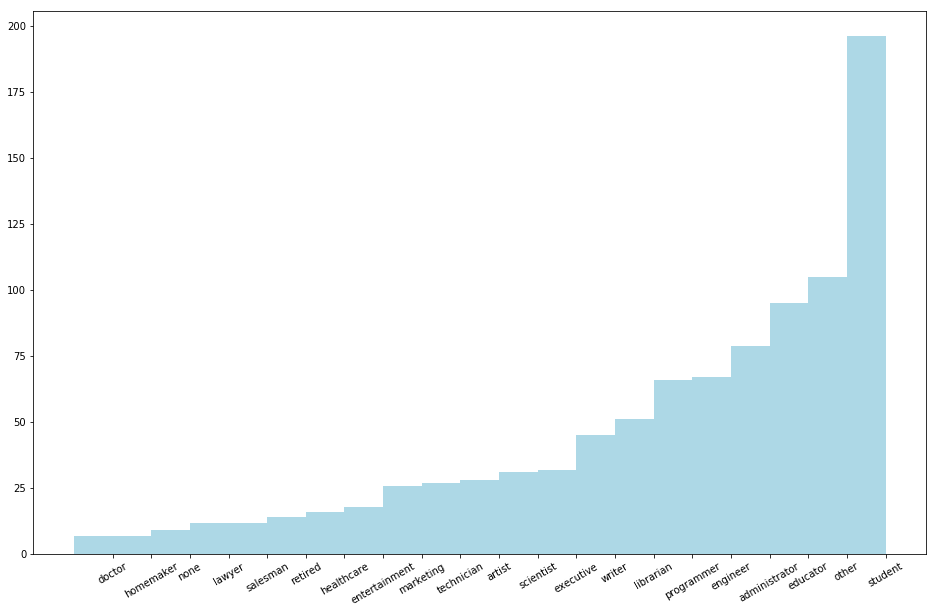

In [20]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [23]:
# Note we can also use the Spark RDD method 'countByValue' to generate the occupation counts
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print "Map-reduce approach:"
print dict(count_by_occupation2)
print ""
print "countByValue approach:"
print dict(count_by_occupation)

Map-reduce approach:
{u'administrator': 79, u'retired': 14, u'lawyer': 12, u'healthcare': 16, u'marketing': 26, u'executive': 32, u'scientist': 31, u'student': 196, u'technician': 27, u'librarian': 51, u'programmer': 66, u'salesman': 12, u'homemaker': 7, u'engineer': 67, u'none': 9, u'doctor': 7, u'writer': 45, u'entertainment': 18, u'other': 105, u'educator': 95, u'artist': 28}

countByValue approach:
{u'administrator': 79, u'writer': 45, u'retired': 14, u'lawyer': 12, u'doctor': 7, u'marketing': 26, u'executive': 32, u'none': 9, u'entertainment': 18, u'healthcare': 16, u'scientist': 31, u'student': 196, u'educator': 95, u'technician': 27, u'librarian': 51, u'programmer': 66, u'artist': 28, u'salesman': 12, u'other': 105, u'homemaker': 7, u'engineer': 67}


## Exploring the Movie Dataset

In [10]:
movie_data = sc.textFile("%s/ml-100k/u.item" % PATH)
print movie_data.first()
num_movies = movie_data.count()
print "Movies: %d" % num_movies

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


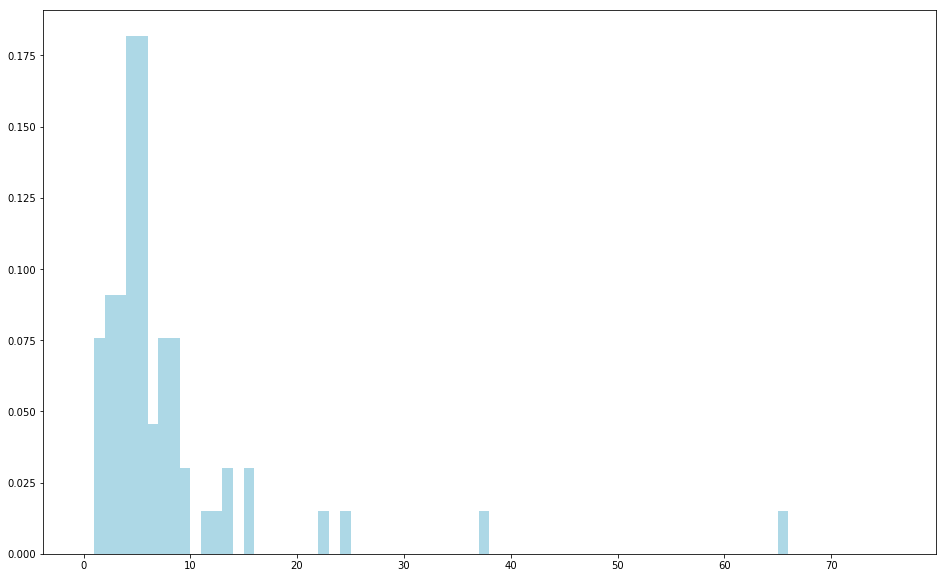

In [19]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 # there is a 'bad' data point with a blank year, which we set to 1900 and will filter out later

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
# we filter out any 'bad' data points here
years_filtered = years.filter(lambda x: x != 1900)
# plot the movie ages histogram
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
hist(values, bins=bins, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

## Exploring the Rating Dataset

In [12]:
rating_data_raw = sc.textFile("%s/ml-100k/u.data" % PATH)
print rating_data_raw.first()
num_ratings = rating_data_raw.count()
print "Ratings: %d" % num_ratings

196	242	3	881250949
Ratings: 100000


In [13]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print "Min rating: %d" % min_rating
print "Max rating: %d" % max_rating
print "Average rating: %2.2f" % mean_rating
print "Median rating: %d" % median_rating
print "Average # of ratings per user: %2.2f" % ratings_per_user
print "Average # of ratings per movie: %2.2f" % ratings_per_movie

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00


In [14]:
# we can also use the stats function to get some similar information to the above
ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

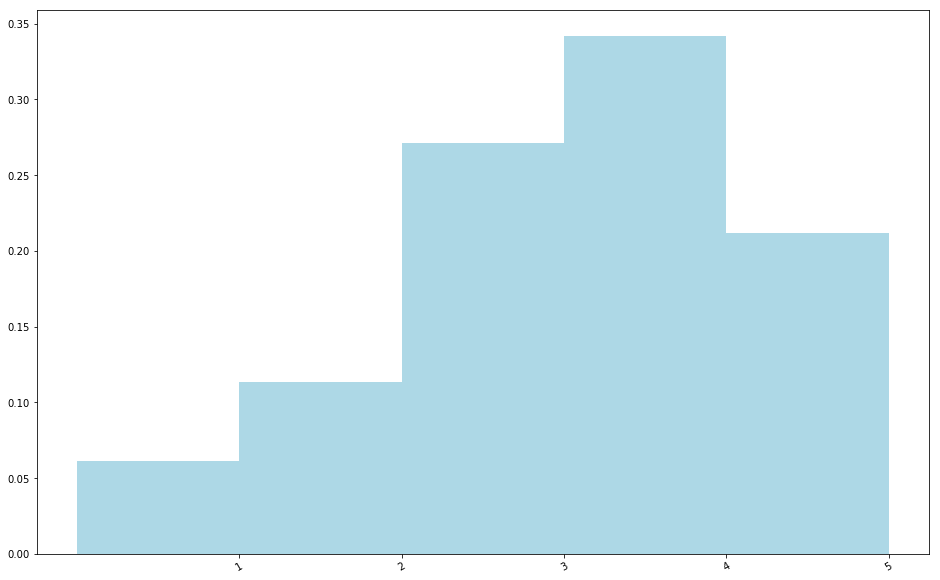

In [15]:
# create plot of counts by rating value
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
# we normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [16]:
# to compute the distribution of ratings per user, we first group the ratings by user id
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).\
    groupByKey() 
# then, for each key (user id), we find the size of the set of ratings, which gives us the # ratings for that user 
user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
user_ratings_byuser.take(5)

[(2, 62), (4, 24), (6, 211), (8, 59), (10, 184)]

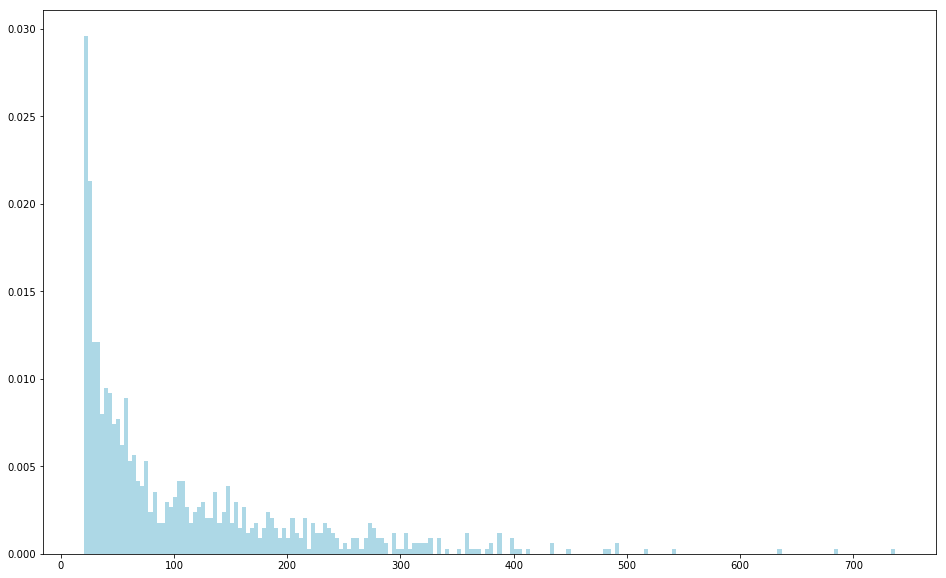

In [17]:
# and finally plot the histogram
user_ratings_byuser_local = user_ratings_byuser.map(lambda (k, v): v).collect()
hist(user_ratings_byuser_local, bins=200, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

## Filling in Bad or Missing Values

In [27]:
years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).filter(lambda yr: yr != 1900).collect()
years_pre_processed_arr = np.array(years_pre_processed)   
print years_pre_processed_arr
# first we compute the mean and median year of release, without the 'bad' data point
mean_year = np.mean(years_pre_processed_arr[years_pre_processed_arr!=1900])
median_year = np.median(years_pre_processed_arr[years_pre_processed_arr!=1900])
idx_bad_data = np.where(years_pre_processed_arr==1900)
if len(idx_bad_data):
    years_pre_processed_arr[idx_bad_data] = median_year
print "Mean year of release: %d" % mean_year
print "Median year of release: %d" % median_year
print "Index of '1900' after assigning median: %s" % np.where(years_pre_processed_arr == 1900)[0]

[1995 1995 1995 ..., 1998 1994 1996]
Mean year of release: 1989
Median year of release: 1995
Index of '1900' after assigning median: []


##Feature Extraction

### Categorical Features: _1-of-k_ Encoding of User Occupation

In [28]:
all_occupations = user_fields.map(lambda fields: fields[3]).distinct().collect()
all_occupations.sort()
# create a new dictionary to hold the occupations, and assign the "1-of-k" indexes
idx = 0
all_occupations_dict = {}
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1
# try a few examples to see what "1-of-k" encoding is assigned
print "Encoding of 'doctor': %d" % all_occupations_dict['doctor']
print "Encoding of 'programmer': %d" % all_occupations_dict['programmer']

Encoding of 'doctor': 2
Encoding of 'programmer': 14


In [29]:
# create a vector representation for "programmer" and encode it into a binary vector
K = len(all_occupations_dict)
binary_x = np.zeros(K)
k_programmer = all_occupations_dict['programmer']
binary_x[k_programmer] = 1
print "Binary feature vector: %s" % binary_x
print "Length of binary vector: %d" % K

Binary feature vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]
Length of binary vector: 21


### Transforming Timestamps into Categorical Features

In [30]:
# a function to extract the timestamps (in seconds) from the dataset
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)
    
timestamps = rating_data.map(lambda fields: int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

[23, 3, 15, 13, 13]

In [31]:
# a function for assigning "time-of-day" bucket given an hour of the day
def assign_tod(hr):
    times_of_day = {
                'morning' : range(7, 12),
                'lunch' : range(12, 14),
                'afternoon' : range(14, 18),
                'evening' : range(18, 23),
                'night' : range(23, 7)
                }
    for k, v in times_of_day.iteritems():
        if hr in v: 
            return k

# now apply the "time of day" function to the "hour of day" RDD
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

[None, None, 'afternoon', 'lunch', 'lunch']

### Simple Text Feature Extraction

In [32]:
# we define a function to extract just the title from the raw movie title, removing the year of release
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)", raw)    # this regular expression finds the non-word (numbers) between parentheses
    if grps:
        return raw[:grps.start()].strip() # we strip the trailing whitespace from the title
    else:
        return raw

# first lets extract the raw movie titles from the movie fields
raw_titles = movie_fields.map(lambda fields: fields[1])
# next, we strip away the "year of release" to leave us with just the title text
# let's test our title extraction function on the first 5 titles
for raw_title in raw_titles.take(5):
    print extract_title(raw_title)

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [33]:
# ok that looks good! let's apply it to all the titles
movie_titles = raw_titles.map(lambda m: extract_title(m))
# next we tokenize the titles into terms. We'll use simple whitespace tokenization
title_terms = movie_titles.map(lambda t: t.split(" "))
print title_terms.take(5)

[[u'Toy', u'Story'], [u'GoldenEye'], [u'Four', u'Rooms'], [u'Get', u'Shorty'], [u'Copycat']]


In [43]:
# next we would like to collect all the possible terms, in order to build out dictionary of term <-> index mappings
all_terms = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collect()
# create a new dictionary to hold the terms, and assign the "1-of-k" indexes
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx +=1
num_terms = len(all_terms_dict)
print "Total number of terms: %d" % num_terms
print "Index of term 'Dead': %d" % all_terms_dict['Dead']
print "Index of term 'Rooms': %d" % all_terms_dict['Rooms']

Total number of terms: 2645


KeyError: 'Dead'

In [45]:
# we could also use Spark's 'zipWithIndex' RDD function to create the term dictionary
all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()
print "Index of term 'Dead': %d" % all_terms_dict2['Dead']
print "Index of term 'Rooms': %d" % all_terms_dict2['Rooms']

Index of term 'Dead': 147
Index of term 'Rooms': 1963


In [46]:
# this function takes a list of terms and encodes it as a scipy sparse vector using an approach 
# similar to the 1-of-k encoding
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Column format>]

## Normalizing Features

### Scaling the Norm of Vectors

In [51]:
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x:\n%s" % normalized_x
print "2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x)

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


 ### Scaling the Norm of Vectors with MLlib's Normalizer

In [101]:
from pyspark.mllib.feature import Normalizer
normalizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()

print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x MLlib:\n%s" % normalized_x_mllib
print "2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
